In [2]:
import requests
from bs4 import BeautifulSoup
import wikipediaapi
import pprint as pp


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import urllib.parse # combine URL components into URL string
import wikipediaapi # query wikipedia through api
import requests # standard for making HTTP requests

from statsmodels.tsa.seasonal import STL # seasonal decompositions
import statsmodels.tsa.stattools as smt


import pickle #  to serialize and deserialize objects in Python

from scipy import signal
import warnings

In [5]:
def create_dataframe_language(list_categories, lan):
    
    """
    Creates a dataframe that contains the total weekly pageviews for a list of categories
    param: list_categories: list of the categories of interest in English
    param: lan: Wikipedia language 
    return: dataframe with a date column and one column per category that contains the total weekly pageviews
    """
    
    pageviews = pd.DataFrame()

    for category in list_categories:
        if lan != 'en':
            transl_cat = translate(category,lan)
            titles_pages = pd.Series(get_list_wikipages(transl_cat,lan)).dropna().drop_duplicates()
        else:
            titles_pages = pd.Series(get_list_wikipages(category)).dropna().drop_duplicates()

        pageviews[category] = np.zeros(252)
                            
        titles_pages.apply(lambda x: subpage_helper(x, category, pageviews, lan))

            
    pageviews['date'] = pageviews['date'].apply(lambda x: str(x[:4])+'-'+str(x[4:6])+'-'+str(x[6:8])) 
    pageviews['date'] = pd.to_datetime(pageviews['date'], format = '%Y-%m-%d')

    return pageviews

In [7]:
def get_list_wikipages(category: str, location: str) -> list:
    
    """
    Gets the list of all Wikipedia articles in one category in one language
    param: category: title of the translated Wikipedia category
    param: location: Wikipedia language  
    return: list of Wikipedia pages titles
    """
    
    url = f'https://{location}.wikipedia.org/w/api.php?action=query&cmlimit=max&cmtitle=Category%3A{category}&list=categorymembers&format=json'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    r = requests.get(url, headers=headers)
    
    all_pages = r.json()['query']['categorymembers']
    result = []
    for pages in all_pages:
        result.append(pages['title'].replace(' ', '_'))
    return result

In [8]:
def get_article_views(article: str, location: str,start_date='20180101', end_date='20221101'):
    
    """
    Gets the weekly pageviews for one Wikipedia page in one language in the desired period
    param: article: title of the Wikipedia page
    param: location: Wikipedia language 
    param: start_date: beginning of the desired period 
    param: end_date: end of the desired period 
    return: dataframe column with the weekly pageviews
    """
    
    result = {}
    project = f'{location}.wikipedia.org'
    title = urllib.parse.quote(article)

    url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{project}/all-access/all-agents/{title}/daily/{start_date}/{end_date}'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    #print(url)
    r = requests.get(url, headers=headers)

    if list(r.json().keys())[0] != "type":
        all_views = r.json()['items']
        
        for daily_views in all_views:
            result[daily_views['timestamp']] = daily_views['views']

        result = pd.DataFrame(result,index=[article]).transpose()
        result = result.fillna(0)
        result = result.rolling(7).mean().dropna()[::7]

    return result

In [3]:
def get_covid_data():
    # Create a Wikipedia API object
    wiki_wiki = wikipediaapi.Wikipedia("en")

    # Define the title of the Wikipedia page for COVID-19
    page_title = "COVID-19_pandemic"

    # Get the page content
    page = wiki_wiki.page(page_title)

    # Check if the page exists
    if page.exists():
        # Access specific sections or information from the page
        # For example, let's print the text of the "Overview" section
        overview_section = page.section_by_title("Overview")
        if overview_section:
            print(overview_section.text[:500])  # Print the first 500 characters of the section
        else:
            print("Overview section not found.")
    else:
        print(f"The Wikipedia page for '{page_title}' does not exist.")

In [47]:
from urllib import request
from bs4 import BeautifulSoup
import json
import pytrends

url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/all-agents/Confidence/daily/20191001/20230213'
html = request.urlopen(url).read()
soup = BeautifulSoup(html,'html.parser')
site_json=json.loads(soup.text)
df=pd.DataFrame(site_json['items'])
print(site_json)
print([d.get('views') for d in site_json['items'] if d.get('views')])
df=df[['timestamp','views']]
df

{'items': [{'project': 'en.wikipedia', 'article': 'Confidence', 'granularity': 'daily', 'timestamp': '2019100100', 'access': 'all-access', 'agent': 'all-agents', 'views': 428}, {'project': 'en.wikipedia', 'article': 'Confidence', 'granularity': 'daily', 'timestamp': '2019100200', 'access': 'all-access', 'agent': 'all-agents', 'views': 415}, {'project': 'en.wikipedia', 'article': 'Confidence', 'granularity': 'daily', 'timestamp': '2019100300', 'access': 'all-access', 'agent': 'all-agents', 'views': 399}, {'project': 'en.wikipedia', 'article': 'Confidence', 'granularity': 'daily', 'timestamp': '2019100400', 'access': 'all-access', 'agent': 'all-agents', 'views': 366}, {'project': 'en.wikipedia', 'article': 'Confidence', 'granularity': 'daily', 'timestamp': '2019100500', 'access': 'all-access', 'agent': 'all-agents', 'views': 321}, {'project': 'en.wikipedia', 'article': 'Confidence', 'granularity': 'daily', 'timestamp': '2019100600', 'access': 'all-access', 'agent': 'all-agents', 'views':

,timestamp,views
0,2019100100,428
1,2019100200,415
2,2019100300,399
3,2019100400,366
4,2019100500,321
...,...,...
1227,2023020900,713
1228,2023021000,605
1229,2023021100,579
1230,2023021200,637


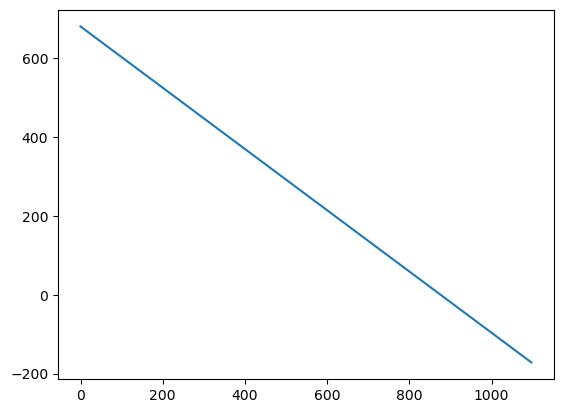

In [45]:
#Use df to show a graph of the views over time
#df.plot(x='timestamp',y='views')


#do a linear regression for this graph
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,df.views)
line = slope*df.index+intercept
plt.plot(line)
plt.show()



